There are a few business logic requirements that the algorithm should satisfy:
1. Nodes connected to higher risk nodes have higher associated risk scores, ceteris paribus
2. A node's associated risk scores decreases as its degree of connectivity to a high risk node increases, ceteris paribus
3. A node's associated risk score should not be affected by the length of the path it lies on, ceteris paribus
4. A node's associated risk score should not be function of the origin risk node's outdegree, ceteris paribus

In [30]:
import numpy as np
import networkx as nx
import pandas as pd

The Personal Page Rank (PPR) algorithm's ability to satisfy these principles is examined, starting with the first.


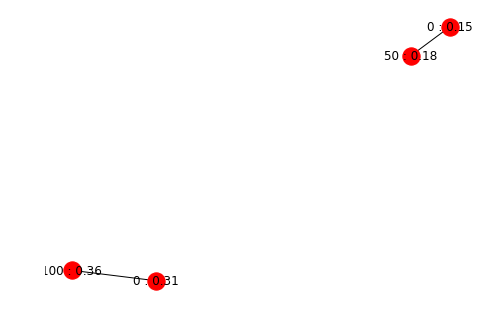

In [31]:
G1 = nx.Graph()
G1.add_nodes_from(list(range(4)))
G1.add_edges_from([(0,1),(2,3)])
G1_risk_dict = {0: 100,
                1: 0,
                2: 50,
                3: 0}
max_iter = 100
G1_ppr = nx.pagerank(G1, max_iter=max_iter, personalization=G1_risk_dict)
for (k1,v1), (k2,v2) in zip(G1_risk_dict.items(), G1_ppr.items()):
    G1_ppr[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw(G1, labels=G1_ppr, with_labels=True)

PPR satisfies the first requirement. Its ability to satisfy the the second requirement is now examined.

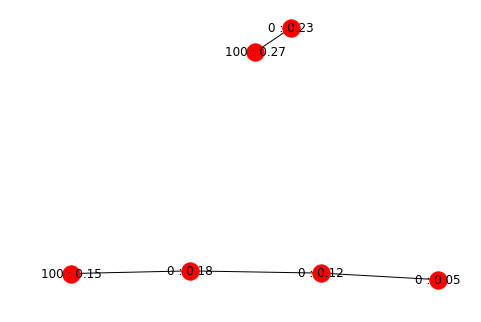

In [32]:
G1.add_nodes_from([4, 5])
G1.add_edges_from([(1,4), (4,5)])
G2_risk_dict = G1_risk_dict.copy()
G2_risk_dict.update({2: 100, 4: 0, 5: 0})
G3_ppr = nx.pagerank(G1, max_iter=max_iter, personalization=G2_risk_dict)
for (k1,v1), (k2,v2) in zip(G2_risk_dict.items(), G3_ppr.items()):
    G3_ppr[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw(G1, labels=G3_ppr, with_labels=True)

While PPR satisfies the second requirement, it fails for the third: the first nodes from each high risk node should have equal scores. It can now be shown that PPR also fails for the fourth requirement.

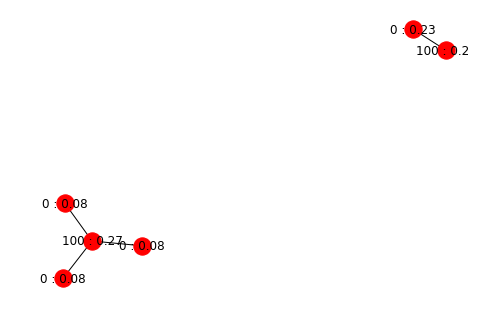

In [34]:
G1.remove_edges_from([(1,4),(4,5)])
G1.add_edges_from([(0,4),(0,5)])
G4_ppr = nx.pagerank(G1, max_iter=max_iter, personalization=G3_risk_dict)
for (k1,v1), (k2,v2) in zip(G3_risk_dict.items(), G4_ppr.items()):
    G4_ppr[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw(G1, labels=G4_ppr, with_labels=True)

One might propose proportionally increasing the risk score by the node's outdegree.

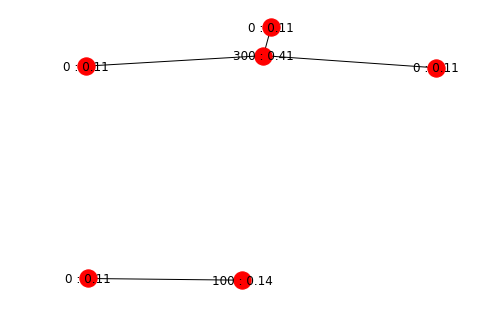

In [35]:
G4_risk_dict = G3_risk_dict.copy()
G4_risk_dict.update({0: 300})
G5_ppr = nx.pagerank(G1, max_iter=max_iter, personalization=G4_risk_dict)
for (k1,v1), (k2,v2) in zip(G4_risk_dict.items(), G5_ppr.items()):
    G5_ppr[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw(G1, labels=G5_ppr, with_labels=True)

While the solution works for immediate nodes, it creates problems for downstream nodes.

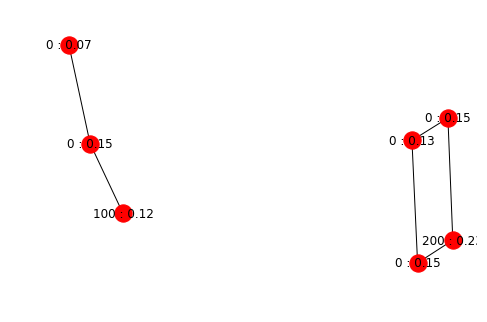

In [38]:
G1.remove_edges_from([(0,5)])
G1.add_edges_from([(1,5),(4,5)])
G1.add_node(6)
G1.add_edge(3, 6)
G4_risk_dict.update({0: 200, 6: 0})
G6_ppr = nx.pagerank(G1, max_iter=max_iter, personalization=G4_risk_dict)
for (k1,v1), (k2,v2) in zip(G4_risk_dict.items(), G6_ppr.items()):
    G6_ppr[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw_spring(G1, labels=G6_ppr, with_labels=True)

Hence, a new solution, Shortest Path Associated Risk Score (SPARS) was developed to generate an associated risk score that satisfies all four requirements.

The algorithm is outlined below:
1. Get the length of all shortest paths between all nodes in the graph
2. Generate a unidirectional chain with length equal to the diameter of the graph
3. Run PPR on the chain
4. Removing the PPR score from the origin node, normalize the remaining scores
5. Replace the shortest path length between all nodes with the corresponding PPR score obtained from the chain
6. Generate a triangular matrix and multiply with a vector of risk scores
7. Subtract the initial risk scores from the scores obtained in Step 5 

In [44]:
def SPARS(G, risk_dict):
    shortest_paths = [path_dict for path_dict in nx.shortest_path_length(G)]
    path_df = []
    for item in shortest_paths:
        path_data = pd.DataFrame(list(item[1].items()), columns=['DESTINATION NODE', 'PATH LENGTH'])
        path_data['ORIGIN NODE'] = item[0]
        path_df.append(path_data)
    path_df = pd.concat(path_df)
    # Calculate the page rank distribution
    max_path = np.max(path_df['PATH LENGTH']) + 1
    path_graph = nx.path_graph(max_path, create_using=nx.DiGraph())
    path_graph_dict = dict(zip(list(path_graph.nodes()), [1] + [0] * (max_path - 1)))
    path_pr = nx.pagerank(path_graph, personalization=path_graph_dict)
    path_pr = pd.DataFrame([list(path_pr.keys()), list(path_pr.values())]).transpose()
    path_pr.columns = ['PATH LENGTH', 'WEIGHT']
    path_pr.iloc[0,1] = 0
    path_pr['WEIGHT'] = path_pr['WEIGHT'] / sum(path_pr['WEIGHT'])
    path_df = pd.merge(path_df,
                       path_pr,
                       on='PATH LENGTH',
                       how='left')
    path_df.drop(columns='PATH LENGTH', inplace=True)
    path_df = path_df.pivot_table(index=['ORIGIN NODE'], 
                                  columns='DESTINATION NODE',
                                  values='WEIGHT',
                                  fill_value=0)
    risk_scores = np.array(list(risk_dict.values()))
    assoc_risk_scores = np.dot(path_df, risk_scores) - risk_scores
    return assoc_risk_scores

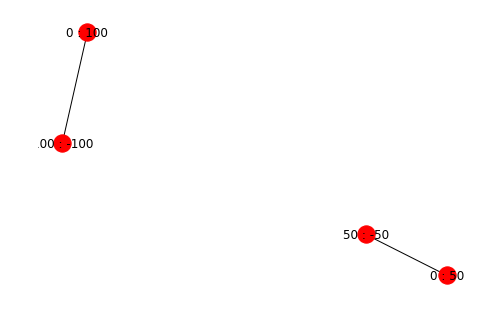

In [48]:
G1 = nx.Graph()
G1.add_nodes_from(list(range(4)))
G1.add_edges_from([(0,1),(2,3)])
G1_risk_dict = {0: 100,
                1: 0,
                2: 50,
                3: 0}
max_iter = 100
G1_spars = SPARS(G1, G1_risk_dict)
G1_spars = dict(zip(G1_risk_dict.keys(), G1_spars))
for (k1,v1), (k2,v2) in zip(G1_risk_dict.items(), G1_spars.items()):
    G1_spars[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw_spring(G1, labels=G1_spars, with_labels=True)

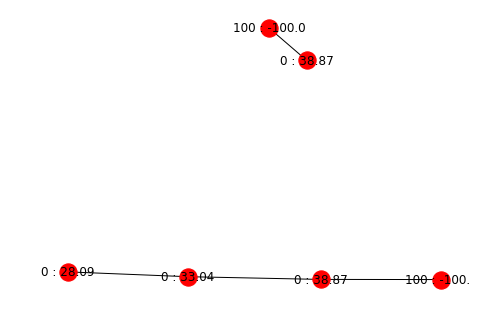

In [49]:
G1.add_nodes_from([4, 5])
G1.add_edges_from([(1,4), (4,5)])
G2_risk_dict = G1_risk_dict.copy()
G2_risk_dict.update({2: 100, 4: 0, 5: 0})
G3_spars = SPARS(G1, G2_risk_dict)
G3_spars = dict(zip(G2_risk_dict.keys(), G3_spars))
for (k1,v1), (k2,v2) in zip(G2_risk_dict.items(), G3_spars.items()):
    G3_spars[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw_spring(G1, labels=G3_spars, with_labels=True)

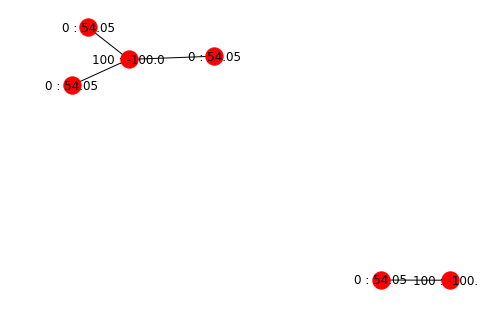

In [50]:
G1.remove_edges_from([(1,4),(4,5)])
G1.add_edges_from([(0,4),(0,5)])
G4_spars = SPARS(G1, G3_risk_dict)
G4_spars = dict(zip(G3_risk_dict.keys(), G4_spars))
for (k1,v1), (k2,v2) in zip(G3_risk_dict.items(), G4_spars.items()):
    G4_spars[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw_spring(G1, labels=G4_spars, with_labels=True)

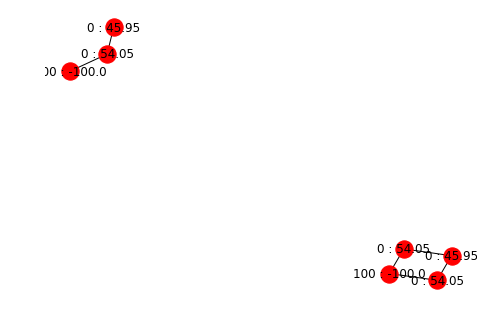

In [51]:
G4_risk_dict = G3_risk_dict.copy()
G4_risk_dict.update({0: 300})
G1.remove_edges_from([(0,5)])
G1.add_edges_from([(1,5),(4,5)])
G1.add_node(6)
G1.add_edge(3, 6)
G4_risk_dict.update({0: 100, 6: 0})
G6_spars = SPARS(G1, G4_risk_dict)
G6_spars = dict(zip(G4_risk_dict.keys(), G6_spars))
for (k1,v1), (k2,v2) in zip(G4_risk_dict.items(), G6_spars.items()):
    G6_spars[k2] = str(v1) + ' : ' + str(round(v2, 2))
nx.draw_spring(G1, labels=G6_spars, with_labels=True)